### Import python library

In [80]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow.keras.backend as K 

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go

from math import sqrt

### 1. Read data: augment_24group_1620.csv필요

In [2]:
data = pd.read_csv("model_input_data/augment_24group_1620.csv")

#### 1) 변수 설정

In [54]:
team_val = 'HH'
year_val = 2016

#### 2) Train 전처리

In [55]:
tmp = data.copy()


tmp = tmp[tmp["YEAR"]!=2020]
tmp.head(50)

train = tmp[tmp["IDX"]!=777]
test = tmp[tmp["IDX"]==777]

In [56]:
ttmp = train[(train["T_ID"]==team_val)]
ttmp = ttmp[(ttmp["YEAR"]==year_val)]
ttmp

,T_ID,YEAR,PCT,IDX,MERGE_IDX,HEADER_NO,era,avg,vs_era,vs_avg,...,K_9,vs_ERA,H_A,vs_K_9,vs_FIP,H_9,oSLG,vs_OPS,vs_WHIP,P2_WHIP_RT
99,HH,2016,0.291667,1,1,0,5.791667,0.264242,3.728371,0.280193,...,7.574750,3.821167,0.541667,7.715417,17.785458,9.805375,0.440208,0.813708,1.375542,2.595583
100,HH,2016,0.391304,2,2,0,7.394881,0.289072,5.467290,0.329370,...,6.368083,5.576042,0.375000,6.834375,25.564625,12.042167,0.469708,0.880583,1.611250,2.383458
101,HH,2016,0.521739,3,3,0,4.764706,0.284884,4.726027,0.279395,...,6.308333,4.860833,0.583333,7.486875,25.086250,9.926042,0.403667,0.749875,1.480500,1.855500
102,HH,2016,0.608696,4,4,0,5.010721,0.314581,6.458333,0.276923,...,6.903292,6.583917,0.416667,5.725667,26.727583,9.713583,0.383917,0.721292,1.770458,1.616375
103,HH,2016,0.500000,5,5,0,6.412510,0.293083,5.915493,0.304651,...,7.526667,5.953583,0.500000,6.942708,22.707208,11.031000,0.462792,0.822875,1.531083,2.183125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,HH,2016,0.458333,4,93,0,6.118869,0.290247,5.561321,0.295943,...,7.224583,5.635417,0.458333,6.973958,20.825250,10.618125,0.447375,0.797458,1.525500,2.093958
192,HH,2016,0.391304,1,94,0,7.566855,0.284360,5.509346,0.329384,...,6.284750,5.622917,0.375000,6.975000,25.658375,12.083833,0.469708,0.882292,1.595625,2.402250
193,HH,2016,0.565217,2,95,0,4.459459,0.287048,4.871560,0.276023,...,6.448958,5.027500,0.625000,7.387917,25.399917,9.686458,0.400417,0.742667,1.485708,1.756292
194,HH,2016,0.608696,3,96,0,5.176364,0.314154,6.458333,0.282353,...,6.856417,6.583917,0.416667,5.767333,27.468333,9.994833,0.385708,0.728542,1.788958,1.703958


* timestep = 2를 만들기 위해 data shift

In [57]:
aaa = ttmp.loc[:,["IDX","MERGE_IDX","PCT"]]

for i in range(1,3):
    for c in list(set(list(ttmp.columns))-set(['T_ID','YEAR'])):
        aaa.loc[:,'shift_{}_{}'.format(c,i)] = ttmp.loc[:,c].shift(i)
        
# aaa.loc[:,["IDX","MERGE_IDX","PCT"]] = ttmp.loc[:,["IDX","MERGE_IDX","PCT"]]

In [58]:
ttmp = aaa.copy()

In [59]:
ttmp.dropna(inplace = True)
ttmp_idx = list(ttmp.index)
drop_idx = []
for i in ttmp_idx:
    idx_num = ttmp.loc[i,'IDX']
    if idx_num < ttmp.loc[i,'shift_IDX_1'] or idx_num < ttmp.loc[i,'shift_IDX_2']:
        drop_idx.append(i)

In [60]:
shift_data = ttmp.drop(drop_idx).reset_index(drop = True)

# shift_data = pd.concat([shift_data, pd.get_dummies(data.T_ID)], axis = 1)

no_shift_lst= []
for i in list(shift_data.columns):
    if 'shift' not in i:
        no_shift_lst.append(i)

In [61]:
X_train = shift_data.drop(no_shift_lst,axis = 1)
y_train = shift_data[["PCT"]]

In [62]:
X_train.shape, y_train.shape

((49, 140), (49, 1))

#### 4) Test 전처리

In [63]:
sel_col = list(test.columns)

tmp5 = data[(data["IDX"]==5)&(data["T_ID"]==team_val)][sel_col]
tmp4 = data[(data["IDX"]==4) & (data["MERGE_IDX"]==4)&(data["T_ID"]==team_val)][sel_col]

In [64]:
test_df = pd.concat([test[test["T_ID"]==team_val],tmp5,tmp4], axis = 0).sort_values(by=["YEAR","IDX"])

In [65]:
test_df = test_df[test_df["YEAR"]== year_val]

In [66]:
bbb = test_df.loc[:,["IDX","MERGE_IDX","PCT"]]

for i in range(1,3):
    for c in list(set(list(test_df.columns))-set(['T_ID','YEAR'])):
        bbb.loc[:,'shift_{}_{}'.format(c,i)] = test_df.loc[:,c].shift(i)
        
# bbb.loc[:,["IDX","MERGE_IDX","PCT"]] = test_df.loc[:,["IDX","MERGE_IDX","PCT"]]


# for c in list(set(list(test_df.columns))-set(['T_ID','YEAR'])):
#     for i in range(1,3):
#         test_df.loc[:,'shift_{}_{}'.format(c,i)] = test_df.loc[:,c].shift(i)

# for i in range(1,3):
#     test_df.loc[:,'shift_{}_{}'.format('PCT',i)] = test_df.loc[:,'PCT'].shift(i)

In [67]:
test_df = bbb.copy()

In [68]:
test_tmp = test_df[test_df["IDX"]==777]
X_test = test_tmp.drop(no_shift_lst,axis = 1)
y_test = test_tmp[["PCT"]]

In [69]:
X_test

,shift_vs_era_1,shift_vs_RC_1,shift_WHIP_1,shift_vs_BA_1,shift_vs_SECA_1,shift_oSLG_1,shift_SECA_1,shift_avg_1,shift_OBP_1,shift_CB_WHIP_RT_1,...,shift_vs_AVG_2,shift_oOBP_2,shift_vs_K_9_2,shift_RC_2,shift_vs_GPA_2,shift_BB_9_2,shift_wOBA_2,shift_H_9_2,shift_BA_2,shift_vs_OBP_2
98,5.915493,1.226667,1.653083,0.298208,0.366125,0.462792,0.30525,0.293083,0.3505,2.363833,...,0.270958,0.327333,5.725667,1.345917,0.249167,3.775625,0.433958,9.713583,0.309875,0.344333


#### 4) input shape로 변경 (row, timestep=2, feature)

ex) 
timestep = 2

* X_train_v 구성예시: [[1 ~ 24경기 데이터, 25 ~ 48경기 데이터], [49 ~ 72경기 데이터, 73 ~ 96경기 데이터] ]  
X_train_v.shape >> (2,2*x)             # x: 각 24group에 대한 변수 개수
* y_train_v 구성예시: 97 ~ 120 경기 승률

=> reshape

* X_train_v.shape >> (2,2,x)  # row, timestep, feature

In [70]:
X_train_v = X_train.values
y_train_v = y_train.values

X_test_v = X_test.values
y_test_v = y_test.values

In [71]:
X_train_v.shape, y_train_v.shape, X_test_v.shape, y_test_v.shape

((49, 140), (49, 1), (1, 140), (1, 1))

In [72]:
X_train_t = X_train_v.reshape(X_train_v.shape[0], 2,70)
X_test_t = X_test_v.reshape(X_test_v.shape[0], 2,70)

### 2. 모델 구성(LSTM)
- optimizer: RMSprop -> lr(learning rate) 조절
- LSTM: 모델이 계속 동일한 결과값이 나올 때, input 뉴런 개수를 늘려야 한다는 글을 읽고 계속 input 노드 개수를 바꿔주면서 모델 생성중
- loss: MSE

- early_stop: patience를 크게하면 과적합 되는 경우가 있어서 최대한 작게 설정해둠
- batch_size: 모델이 계속 동일한 결과값이 나올 때, 데이터가 적어 batch size를 줄여보라는 글을 읽고 1로 설정해둠

In [73]:
K.clear_session() 

model = Sequential()
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.add(LSTM(200,input_shape = (2,70))) # (timestep, feature)
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               216800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 217,001
Trainable params: 217,001
Non-trainable params: 0
_________________________________________________________________


In [74]:
early_stop = EarlyStopping(monitor='loss', mode = 'min',patience=2, verbose=1)


hist1 = model.fit(X_train_t, y_train_v, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Train on 49 samples
Epoch 1/100
49/49 [==============================] - 4s 90ms/sample - loss: 0.0234 - mae: 0.0961
Epoch 2/100
49/49 [==============================] - 0s 6ms/sample - loss: 0.0045 - mae: 0.0565
Epoch 3/100
49/49 [==============================] - 0s 7ms/sample - loss: 0.0039 - mae: 0.0513
Epoch 4/100
49/49 [==============================] - 0s 7ms/sample - loss: 0.0039 - mae: 0.0520
Epoch 5/100
49/49 [==============================] - 0s 7ms/sample - loss: 0.0042 - mae: 0.0527
Epoch 6/100
49/49 [==============================] - 0s 7ms/sample - loss: 0.0042 - mae: 0.0532
Epoch 00006: early stopping


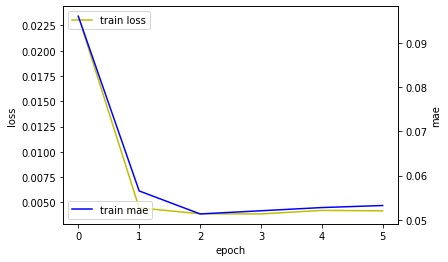

In [76]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist1.history['loss'], 'y', label='train loss')

acc_ax.plot(hist1.history['mae'], 'b', label='train mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mae')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 3. 결과 확인

In [77]:
y_pred = model.predict(X_test_t)

In [78]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.517274,0.5


In [79]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.017273902893066406

### ================================= 결과 ======================================

HH, 2016

In [78]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.517274,0.5


In [79]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.017273902893066406

HH, 2017

In [52]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.464429,0.434783


In [53]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.029646710209224547

HH,2018

In [273]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.498883,0.5


In [274]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.001117318868637085

HH, 2019

In [296]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.335582,0.583333


In [297]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.24775122602780664

In [298]:
test_df[["shift_PCT_1","shift_PCT_2","PCT"]]

,shift_PCT_1,shift_PCT_2,PCT
3042,NaN,NaN,0.250000
3043,0.250,NaN,0.375000
3038,0.375,0.25,0.583333


LG, 2019

In [ ]:
# K.clear_session() 

# model = Sequential()
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

# model.add(LSTM(200,input_shape = (2,70))) # (timestep, feature)
# model.add(Dense(1)) # output = 1
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

# model.summary()

In [173]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.569255,0.541667


In [174]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.027587850888570187

LG, 2018

In [ ]:
# K.clear_session() 

# model = Sequential()
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

# model.add(LSTM(200,input_shape = (2,70))) # (timestep, feature)
# model.add(Dense(1)) # output = 1
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

# model.summary()

In [127]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.414969,0.416667


In [128]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.001697460810343443

LG, 2017

In [ ]:
# K.clear_session() 

# model = Sequential()
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

# model.add(LSTM(200,input_shape = (2,70))) # (timestep, feature)
# model.add(Dense(1)) # output = 1
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

# model.summary()

In [103]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.450553,0.434783


In [104]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.015770063452098693

LG, 2016

In [47]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.516492,0.608696


In [48]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.09220322577849682